### Ход работы

#### Обучающая выборка
Для обучения нейронной сети были взяты символы цифр 6, 7, 2 и 9.

In [2]:
charset = ("6", "7", "2", "9")

In [3]:
from pathlib import Path
train_folder = Path(f'../res/images/train/')
test_folder = Path(f'../res/images/test/')

В качестве обучающей и тестовой выборки взяты изображения, размером 32 на 32 пикселя, на которых изображены цифры, написанные разными шрифтами.

Пример изображений из тестовой выборки:

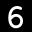

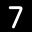

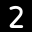

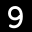

In [4]:
from IPython.core.display import Image

for filename in Path(test_folder).glob('*.png'):
    display(Image(filename=filename))

In [5]:
from PIL import Image

def open_image(path: Path) -> Image.Image:
    with Image.open(path) as im:
        im = im.convert(mode="L")
        return im

In [6]:
def get_data_set(directory: Path) -> dict[str, list[Image.Image]]:
    # ЭТА ЧЕРТОВА СТРОЧКА СНИЗУ ИСПОРТИЛА МНЕ ВЕСЬ ДЕНЬ
    # dataset = {}.fromkeys(charset, [])
    
    dataset = {char: [] for char in charset}

    paths = directory.glob('*.png')

    for path in paths:
        char = path.stem[0]
        dataset[char].append(open_image(path))

    return dataset

#### Функция активации
В качестве функции активации была выбрана **сигмоида** —  непрерывная монотонная возрастающая нелинейная функция.

Ее особенность заключается в том, что для любого входного числа *на выходе она дает число в промежутке от 0 до 1*. 

Это удобно для решения проблемы классификации: значение 1 показывает, что нейрон распознал на изображении цифру, соответствующую его метке, значение 0 — не распознал. Значения между 0 и 1 отображают степень уверенности в распознавании (значение 0.5 является пороговым) 

In [7]:
from math import exp
def sigmoid(x: float) -> float:
    return 1 / (1 + exp(-x))

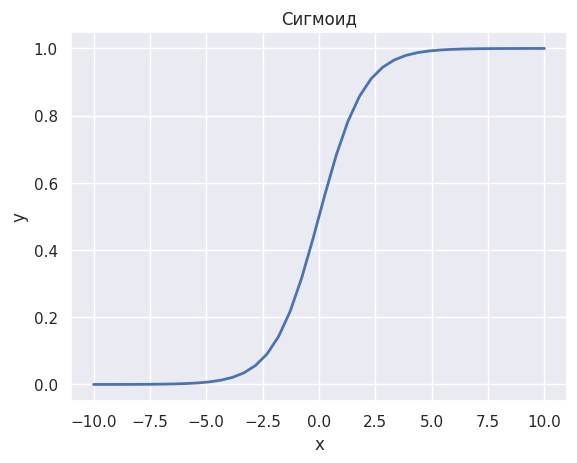

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

x = np.linspace(-10, 10, 40)
y = [sigmoid(x) for x in x]

fig, ax = plt.subplots()

ax.set_title('Сигмоид')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(x, y, linewidth=2.0);

#### Нейрон
Нейрон — вычислительная единица нейронной сети. Нейрон работает с несколькими сигналами и их основе дает выходной сигнал. Выходной сигнал получается применением функции активации на взвешенную сумму входных сигналов.

Нейрон смещения — дополнительный нейрон, который используется для вычисления взвешенной функции вместе с входными сигналами. Нейрон смещения имеет постоянное значение 1 и связь нейрона смещения с выходными нейронами так же имеет вес. Нейрон смещения даёт возможность смещать границу принятия решения, позволяя моделировать более сложные и нелинейные признаки классификации данных.    

Для реализации нейрона в коде был использован *объектно-ориентированный* подход. *Класс* нейрона содержит поле весов входных сигналов, которое является двумерным массивом с размером, соответствующим размеру изображений, и поле веса нейрона смещения. 

Класс имеет следующие *методы*: инициализировать начальные веса, вычислить взвешенную сумму, функция активации, вычислить выходной сигнал, скорректировать веса, получить веса.

Начальные веса инициализируются случайными числами в диапазоне [-0.3; 0.3)

In [9]:
import random
import numpy as np  

class Neuron:

    def __init__(self, size: tuple[int, int]):
        self.init_weights(size)

    def init_weights(self, size: tuple[int, int], min: float = -0.03, max: float = 0.03):
        self._weights = np.random.uniform(min, max, size)
        self._bias = np.random.uniform(min, max)

    def adjust_weights(self, inputs: np.ndarray, delta: float): 
        self._weights += (inputs * delta)
        self._bias += delta

    def get_weights(self):
        return self._weights

    def compute(self, inputs: np.ndarray) -> float:
        weighted_sum = self._weighted_sum(inputs)
        output = self._activation(weighted_sum)

        return output

    def _activation(self, w_sum: float) -> float:
        return sigmoid(w_sum)

    def _weighted_sum(self, inputs: np.ndarray) -> float:
        return float(np.sum(inputs * self._weights) + self._bias)

In [10]:
def flatten_and_shuffle_dataset(dataset: dict[str, list[Image.Image]]) -> list[tuple[str, Image.Image]]:
    flatten = [(char, image) for char, images in dataset.items() for image in images]
    random.shuffle(flatten)
    return flatten

In [11]:
def image_to_ndarray(img: Image.Image) -> np.ndarray:
    return np.array(img)/255

#### Нейронная сеть

Нейронная сеть состоит из входных сигналов, нейрона смещения и выходных нейронов. Каждый из входных сигналов имеет связь с выходным нейроном и соответствующий этой связи вес.

Данная модель состоит из 1024-х входных сигналов (изображения 32х32), 4-х нейронов (на распознавание каждого из 4х символов) и нейрона смещения.

Для нейронной сети так же создан класс, имеющий поля: нейроны выходного слоя, тип: словарь из ключей-символов и значений-нейронов; пороговое значение: 0,5.

Класс сети имеет методы обучения и тестирования. Всего 3 метода обучения, каждый имеет свой критерий останова: превышен лимит эпох, перестают появляться неправильные выходные сигналы, значения весов перестают изменяться. 

Так же реализованы приватные методы: вычислить выходные сигналы, рассчитать дельты, скорректировать веса нейронов, построить тепловую карту нейронов и графики.

Сопоставление нейронов и их меток выполнено с помощью словарей, в которых ключами выступают символы меток. В виде таких словарей хранятся сами нейроны, результаты их вычислений и дельты.

In [15]:
class PerceptronModel:
    OutputDict = dict[str, float]

    def __init__(self, charset: tuple[str, str, str, str] = charset, size: tuple[int, int] = (32,32)):
        self._size = size
        self._neurons = dict(zip(charset, (Neuron(size) for i in charset)))
        self.THRESHOLD = 0.5

    def _process_neurons(self, inputs: np.ndarray) -> OutputDict:
        return {char: neuron.compute(inputs) for char, neuron in self._neurons.items()}

    def _adjust_neurons(self, deltas: OutputDict, inputs: np.ndarray, train_speed: float):
        for label, delta in deltas.items():
            adjustment = delta * train_speed
            self._neurons[label].adjust_weights(inputs, adjustment)
    
    def reset_weights(self, min:float = -0.03, max: float = 0.03):
        for neuron in self._neurons.values():
            neuron.init_weights(self._size, min, max)

    def _calculate_deltas(self, train_char: str, results: OutputDict, train_speed: float) -> tuple[OutputDict, int, int]:
        deltas = {}
        training_total = 0
        training_success = 0

        for neuron_label, res in results.items():
            training_total += 1

            if neuron_label == train_char:
                if res > self.THRESHOLD:
                    training_success += 1
                # if res <=self.THRESHOLD:
                deltas[neuron_label] = (1 - res)

            if neuron_label != train_char:
                # if res > self.THRESHOLD:
                deltas[neuron_label] = (0 - res)
                if res <= self.THRESHOLD:
                    training_success += 1


        return deltas, training_success,  training_total

    
    class PlotData:
        def __init__(self, data: list, title: str, scalex: str = 'linear', scaley: str = 'linear', style: str = '-'):
            self.data = data
            self.title = title
            self.scalex = scalex
            self.scaley = scaley
            self.style = style

    def _plot_weights_and_success(
            self, 
            # initial_weights: dict[str, np.ndarray],
            final_weights: dict[str, np.ndarray],
            graphs_and_titles: list[PlotData]
            ):
        
        import matplotlib.pyplot as plt
        colormap = 'coolwarm'

        fig, hmaps = plt.subplots(1, 4)
        fig.set_size_inches(3, 1)

        import matplotlib.colors

        print('Тепловая карта весов: ')
        for (label, weights), axis in zip(final_weights.items(), hmaps):
            colnorm = matplotlib.colors.CenteredNorm(vcenter=0)
            axis.imshow(weights, cmap=colormap, norm=colnorm)
            
            axis.tick_params(
                axis='both',
                labelbottom = False,
                labelleft = False
            )
            axis.set_title(label)
            axis.grid(False)
        
        fig.tight_layout()


        fig, graphs = plt.subplots(len(graphs_and_titles), 1)
        for axis, pdata in zip(graphs, graphs_and_titles):
            axis.tick_params(axis='y', which='minor')
            from matplotlib.ticker import FormatStrFormatter
            axis.yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
            axis.plot(pdata.data, pdata.style)
            axis.set_xscale(pdata.scalex) # type: ignore
            axis.set_yscale(pdata.scaley) # type: ignore
            axis.set_title(pdata.title)
        fig.tight_layout()
        fig.set_dpi(72)

        plt.show()

    def get_weights(self) -> dict[str, np.ndarray]:
        return {char:neuron.get_weights().copy() for char, neuron in self._neurons.items()}

    
    def train_weights(self, train_speed: float, dataset: dict[str, list[Image.Image]], delta_threshold: float = 0.000001):
        """
        Обучение с критерием останова "веса перестают изменяться"

        Веса меняются только когда дельты не равны нулю, но т.к. функция активации 
        никогда не принимает значения 0 или 1 (только стремится к ним), дельты всегда
        будут отличаться от нуля. С каждой итерацией дельты будут всё ближе и ближе 
        к нулю. 
        Для определения когда дельты будут достаточно малы, чтобы считать, что веса 
        перестанут меняться, заведем параметр порогового значения дельты.
        После каждой итерации обучения будем смотреть на максимальное по модулю 
        значение дельты и сравнивать с пороговым значением. Когда дельта будет ниже
        порогового значения, прерываем обучение.
        """
        print(f'Скорость обучения: {train_speed}') 
        print(f'Пороговое значение: {delta_threshold}')

        # initial_weights = self.get_weights()
        success_epochs = []
        success_iterations = []
        max_deltas = []

        max_abs_delta = 1

        while max_abs_delta > delta_threshold:
            epoch_total_train_count = 0
            epoch_success_train_count = 0
            for dataset_char, image in flatten_and_shuffle_dataset(dataset):
                    inputs = image_to_ndarray(image)
                    results = self._process_neurons(inputs)
                    deltas, success, total = self._calculate_deltas(dataset_char, results, train_speed)
                    epoch_total_train_count += total
                    epoch_success_train_count += success
                    self._adjust_neurons(deltas, inputs, train_speed)
                    max_abs_delta = max([abs(v) for v in deltas.values()])
                    max_deltas.append(max_abs_delta)
                    success_iterations.append(epoch_success_train_count/epoch_total_train_count)
                    if max_abs_delta <= delta_threshold:
                        break
            success_epochs.append(epoch_success_train_count/epoch_total_train_count)

        final_weights = self.get_weights()

        self._plot_weights_and_success(
            # initial_weights, 
            final_weights,
            graphs_and_titles=[
            self.PlotData(success_iterations, 'Успех с каждой итерацией', scalex='log'),
            self.PlotData(max_deltas, 'Максимальная дельта', scaley = 'log', scalex='log', style = 'x'),
            self.PlotData(success_epochs, 'Успех с каждой эпохой', scalex='log'),
            ])

    def train_outputs(self, train_speed: float, dataset: dict[str, list[Image.Image]], success_streak_length: int = 1):
        """
        Обучение с критерием останова "перестают появляться неправильные выходные сигналы"

        Правильными выходными сигналами считаются значения >0.5, если нейрон должен
        распознать символ на изображении, и значения <0.5, если нейрон не должен
        распознать символ на изображении.

        Функция расчета дельт возвращает количество правильных выходных сигналов
        (succes) и общее количество выходных сигналов (total). Когда значение 
        success равно значению total, значит каждый из 4х нейронов дал правильные
        выходные сигналы.

        Однако случай возникновения правильных выходных сигналов на всех нейронах
        может произойти еще на ранних этапах обучения из-за слуайной природы 
        инициализации весов или из-за кратковременного переобучения. 

        Для решения этой проблемы был введен параметр, который
        будет указывать длину серии повторяющихся случаев возникновения правильных выходных 
        сигналов. Таким образом, если несколько итераций подряд перестают 
        появляться неправильные выходные значения и количество таких итераций равно
        значению параметра серии, то обучение прерывается.
        """
        print(f'Скорость обучения: {train_speed}')
        print(f'Длина серии: {success_streak_length}')

        initial_weights = self.get_weights()
        success_epochs = []
        success_iterations = []
        success_iterations_accumulative = []

        success_streak = success_streak_length

        while success_streak > 0:
            epoch_total_train_count = 0
            epoch_success_train_count = 0
            for dataset_char, image in flatten_and_shuffle_dataset(dataset):
                    inputs = image_to_ndarray(image)
                    results = self._process_neurons(inputs)
                    deltas, success, total = self._calculate_deltas(dataset_char, results, train_speed)
                    epoch_total_train_count += total
                    epoch_success_train_count += success
                    self._adjust_neurons(deltas, inputs, train_speed)

                    success_iterations.append(success/total)
                    success_iterations_accumulative.append(epoch_success_train_count/epoch_total_train_count)
                    if success == total:
                    # if max(results, key=results.get) == dataset_char:
                        success_streak -= 1
                        if success_streak == 0:
                            break
                    else: 
                        success_streak = success_streak_length
                        # if success_streak == 0:
                        #     break

            success_epochs.append(epoch_success_train_count/epoch_total_train_count)

        final_weights = self.get_weights()

        self._plot_weights_and_success(
            # initial_weights, 
            final_weights, 
            graphs_and_titles=[
            self.PlotData(success_iterations, 'Успех с каждой итерацией', scalex='log',  style='-'),
            self.PlotData(success_iterations_accumulative, 'Успех с каждой итерацией, аккумулятивно', scalex='log'),
            self.PlotData(success_epochs, 'Успех с каждой эпохой', scalex='log')
            ]
        )

    def train_epochs(self, train_speed: float, dataset: dict[str, list[Image.Image]], epochs: int):
        """
        Обучений с критерием останова "превышен лимит эпох"

        Обучение длится указанное количество эпох. Одна эпоха это итерация обучения
        сети на всех изображениях из датасета один раз. 

        Для подсчета эпох используется счетчик и цикл for, который прерывает обучение
        при истечении количества указанных эпох.
        """

        print(f'Скорость обучения: {train_speed}')
        print(f'Эпох: {epochs}')

        initial_weights = self.get_weights()

        success_epochs = [0.]
        success_iterations = []

        for _ in range(epochs):
            epoch_total_train_count = 0
            epoch_success_train_count = 0
            for dataset_char, image in flatten_and_shuffle_dataset(dataset):
                inputs = image_to_ndarray(image)
                results = self._process_neurons(inputs)
                deltas, success, total = self._calculate_deltas(dataset_char, results, train_speed)
                self._adjust_neurons(deltas, inputs, train_speed)
                epoch_total_train_count += total
                epoch_success_train_count += success
                success_iterations.append(epoch_success_train_count/epoch_total_train_count)

            success_epochs.append(epoch_success_train_count/epoch_total_train_count)

        final_weights = self.get_weights()

        self._plot_weights_and_success(
            # initial_weights, 
            final_weights,
            graphs_and_titles=[
            self.PlotData(success_iterations, 'Успех с каждой итерацией', scalex='log'), 
            self.PlotData(success_epochs, 'Успех с каждой эпохой', scalex='log')
            ]
        )
        # print(f'Успешность последней эпохи: {success_ratios[-1]}')



    def test(self, dataset: dict[str, list[Image.Image]]):
        correct_count = 0
        total_count = 0


        for dataset_char, images in dataset.items():
            for image in images:
                inputs = image_to_ndarray(image)
                results = self._process_neurons(inputs)
                neural_guess = max(results, key=(lambda k: results[k]))

                if neural_guess == dataset_char:
                    correct_count += 1
                total_count += 1

        accuracy = correct_count / total_count
        print(f'Точность классификации при тестировании: {accuracy} \n')

In [16]:
def print_divider():
    print(''.join(['-']*56))

#### Обучение и тестирование

Перцептрон *обучается на 16 изображениях* (по 4 на каждый символ, разными шрифтами). 

Затем, производится *тест распознавательной способности сети на 4 изображениях*, на которых цифры изображены шрифтом, который отсутствовал в обучающей выборке.

##### Замечаниz:
* на каждый алгоритм обучения с разными критериями останова выполнено несколько прогонов с разными параметрами скорости обучения. К разным параметрам скорости обучения подобраны оптимальные, выведенные экспериментальным путем, параметры критерия останова

* параметры критерия останова подбирались таким образом, чтобы обеспечить максимально оптимальную обучаемость нейросети, без недо- или пере-обучения. Во время экспериментальных прогонов, если нейросеть недообучалась и показывала слабую распознавательную способность, параметры критерия останова смягчались, чтобы обучение длилось дольше. И наоборот, если сеть переобучалась, критерий останова ужесточался для преждевременной остановки обучения

Скорость обучения: 1e-05
Пороговое значение: 0.2
Тепловая карта весов: 


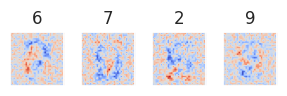

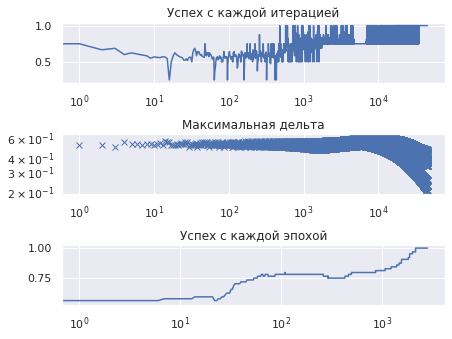

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.0001
Пороговое значение: 0.2
Тепловая карта весов: 


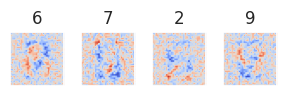

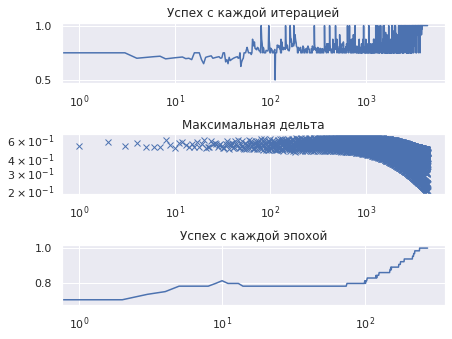

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.001
Пороговое значение: 0.2
Тепловая карта весов: 


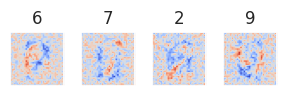

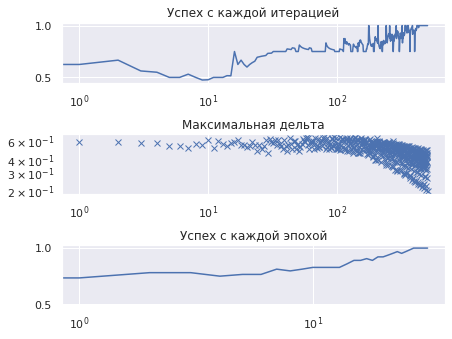

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.01
Пороговое значение: 0.1
Тепловая карта весов: 


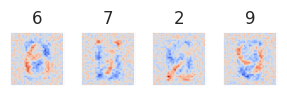

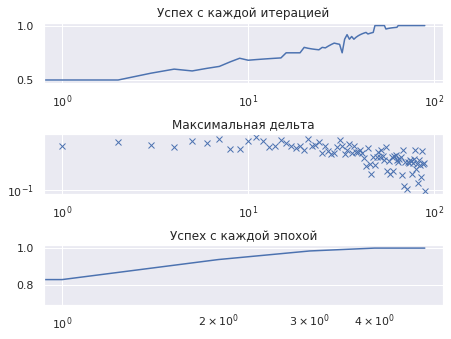

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.1
Пороговое значение: 0.005
Тепловая карта весов: 


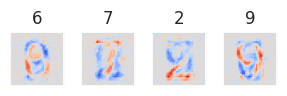

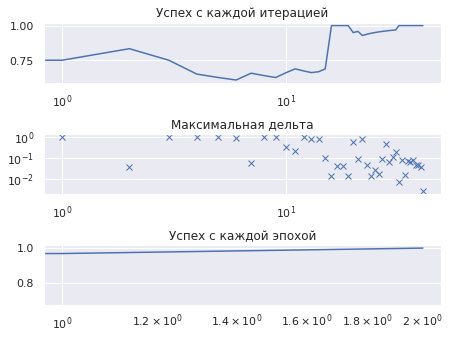

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 1
Пороговое значение: 1e-19
Тепловая карта весов: 


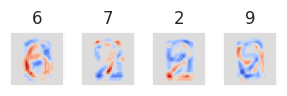

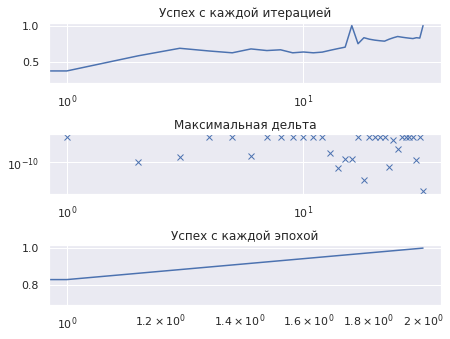

Точность классификации при тестировании: 0.75 

--------------------------------------------------------


In [403]:
weights_model = PerceptronModel()

weights_model.train_weights(train_speed=0.00001, delta_threshold=2e-1, dataset=get_data_set(train_folder))
weights_model.test(dataset=get_data_set(test_folder))
weights_model.reset_weights()
print_divider()

weights_model.train_weights(train_speed=0.0001, delta_threshold=2e-1, dataset=get_data_set(train_folder))
weights_model.test(dataset=get_data_set(test_folder))
weights_model.reset_weights()
print_divider()

weights_model.train_weights(train_speed=0.001, delta_threshold=2e-1, dataset=get_data_set(train_folder))
weights_model.test(dataset=get_data_set(test_folder))
weights_model.reset_weights()
print_divider()

weights_model.train_weights(train_speed=0.01, delta_threshold=1e-1, dataset=get_data_set(train_folder))
weights_model.test(dataset=get_data_set(test_folder))
weights_model.reset_weights()
print_divider()

weights_model.train_weights(train_speed=0.1, delta_threshold=5e-3, dataset=get_data_set(train_folder))
weights_model.test(dataset=get_data_set(test_folder))
weights_model.reset_weights()
print_divider()

weights_model.train_weights(train_speed=1, delta_threshold=1e-19, dataset=get_data_set(train_folder))
weights_model.test(dataset=get_data_set(test_folder))
weights_model.reset_weights()
print_divider()

Скорость обучения: 0.0001
Длина серии: 64
Тепловая карта весов: 


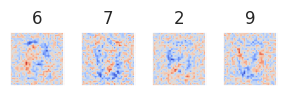

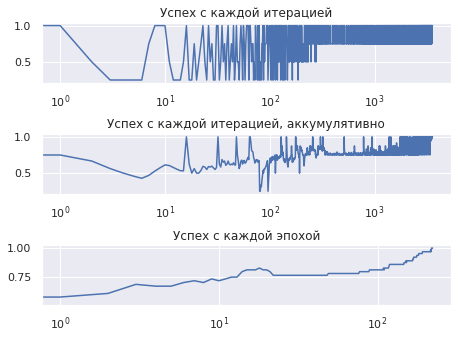

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.001
Длина серии: 32
Тепловая карта весов: 


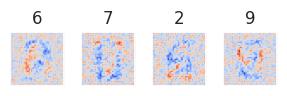

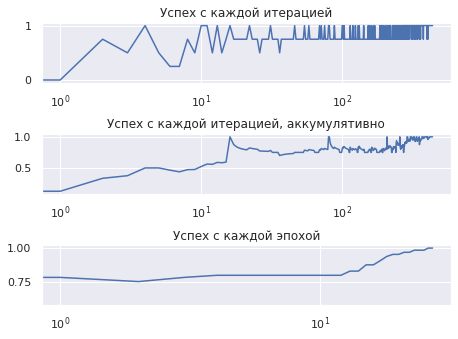

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.01
Длина серии: 16
Тепловая карта весов: 


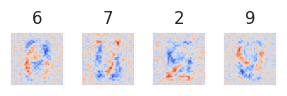

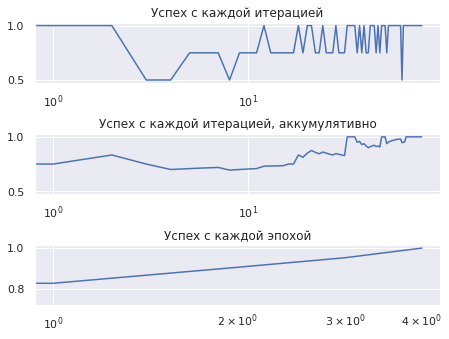

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.1
Длина серии: 8
Тепловая карта весов: 


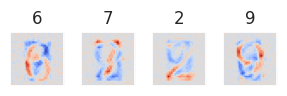

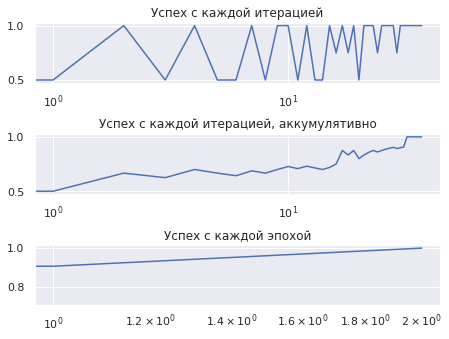

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 1
Длина серии: 16
Тепловая карта весов: 


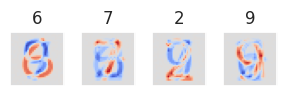

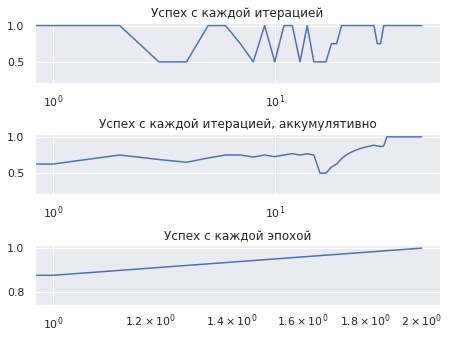

Точность классификации при тестировании: 1.0 

--------------------------------------------------------


In [405]:
outputs_model = PerceptronModel()

outputs_model.train_outputs(train_speed=0.0001, success_streak_length=64, dataset=get_data_set(train_folder))
outputs_model.test(dataset=get_data_set(test_folder))
outputs_model.reset_weights()
print_divider()

outputs_model.train_outputs(train_speed=0.001, success_streak_length=32, dataset=get_data_set(train_folder))
outputs_model.test(dataset=get_data_set(test_folder))
outputs_model.reset_weights()
print_divider()

outputs_model.train_outputs(train_speed=0.01, success_streak_length=16, dataset=get_data_set(train_folder))
outputs_model.test(dataset=get_data_set(test_folder))
outputs_model.reset_weights()
print_divider()

outputs_model.train_outputs(train_speed=0.1, success_streak_length=8, dataset=get_data_set(train_folder))
outputs_model.test(dataset=get_data_set(test_folder))
outputs_model.reset_weights()
print_divider()

outputs_model.train_outputs(train_speed=1, success_streak_length=16, dataset=get_data_set(train_folder))
outputs_model.test(dataset=get_data_set(test_folder))
outputs_model.reset_weights()
print_divider()

Скорость обучения: 1
Эпох: 5
Тепловая карта весов: 


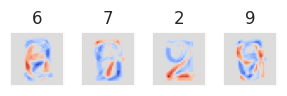

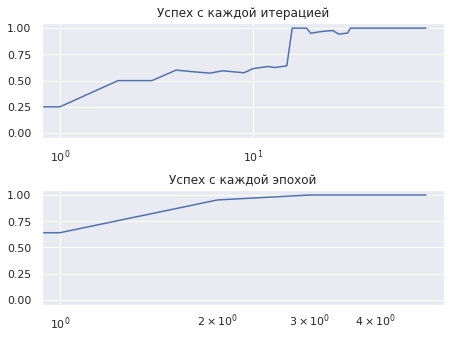

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.1
Эпох: 3
Тепловая карта весов: 


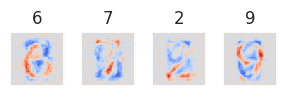

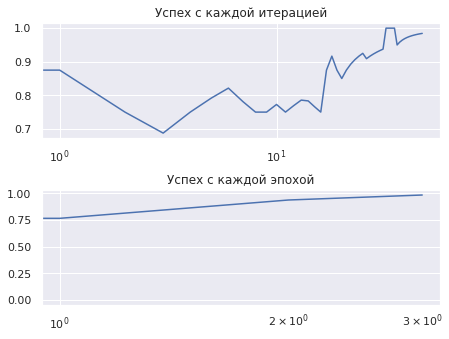

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.01
Эпох: 5
Тепловая карта весов: 


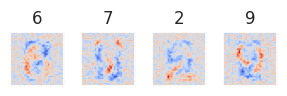

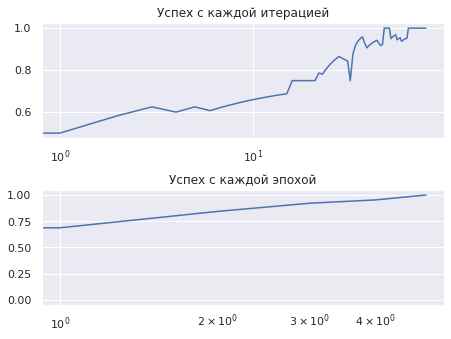

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.001
Эпох: 30
Тепловая карта весов: 


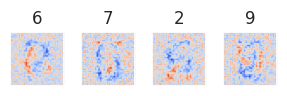

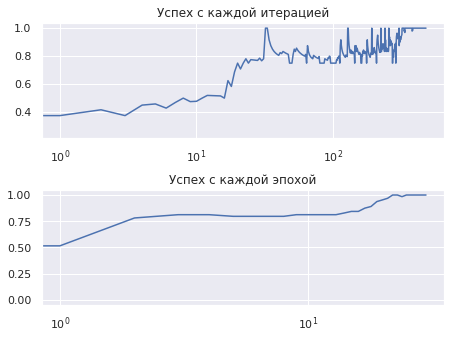

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 0.0001
Эпох: 300
Тепловая карта весов: 


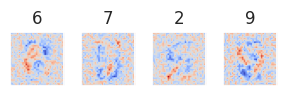

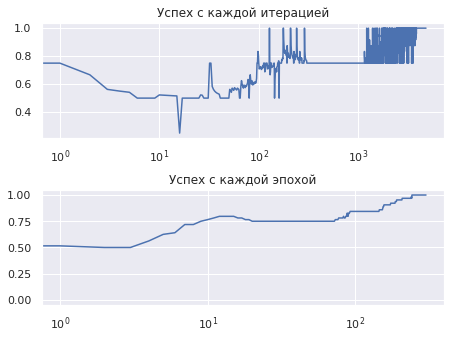

Точность классификации при тестировании: 1.0 

--------------------------------------------------------
Скорость обучения: 1e-05
Эпох: 3000
Тепловая карта весов: 


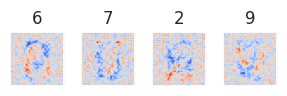

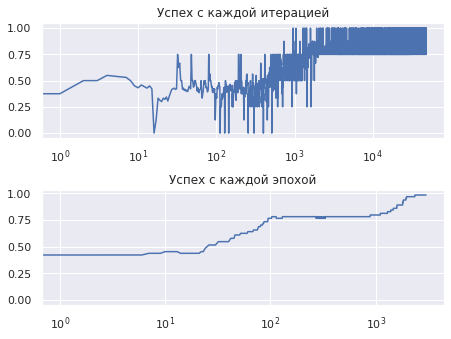

Точность классификации при тестировании: 1.0 

--------------------------------------------------------


In [393]:
epochs_model = PerceptronModel()
epochs = 4

epochs_model.train_epochs(train_speed=1, epochs=5, dataset=get_data_set(train_folder))
epochs_model.test(dataset=get_data_set(test_folder))
print_divider()

epochs_model.reset_weights()
epochs_model.train_epochs(train_speed=0.1, epochs=3, dataset=get_data_set(train_folder))
epochs_model.test(dataset=get_data_set(test_folder))
print_divider()

epochs_model.reset_weights()
epochs_model.train_epochs(train_speed=0.01, epochs=5, dataset=get_data_set(train_folder))
epochs_model.test(dataset=get_data_set(test_folder))
print_divider()

epochs_model.reset_weights()
epochs_model.train_epochs(train_speed=0.001, epochs=30, dataset=get_data_set(train_folder))
epochs_model.test(dataset=get_data_set(test_folder))
print_divider()

epochs_model.reset_weights()
epochs_model.train_epochs(train_speed=0.0001, epochs=300, dataset=get_data_set(train_folder))
epochs_model.test(dataset=get_data_set(test_folder))
print_divider()

epochs_model.reset_weights()
epochs_model.train_epochs(train_speed=0.00001, epochs=3000, dataset=get_data_set(train_folder))
epochs_model.test(dataset=get_data_set(test_folder))
print_divider()

##### Вывод по результатам прогонов: 
Оптимальное значением скорости обучения — 0.01 до 0.1, при таких значениях на оптимальное обучение сети уходит не более 100 эпох и график успешности при обучении выглядит стабильным и возрастающим. 

При больших значениях скорости нейросеть сходится за пару десятков эпох и меньше, но по тепловым картам весов видно, что нейросеть переобучается, т.е. в веса "впечатываются" образы конкретных изображений. 

При меньших же значениях скорости для сведения сети к оптимальному обучению уходит уже в разы больше эпох и к тому же график успешности обучения начинает себя вести нестабильно: появляются сильные скачки и осцилляции между несколькими значениями в процессе обучения. 

Было выявлено, что чем меньше исходный диапазон инициализации весов, тем меньше шумов получается в весах и быстрее нейросеть сходится с оптимальному решению. Однако, при значениях слишком близких к нулю (или инициализация одними нулями), при любых значениях скорости обучения тепловые карты весов получаются слишком "четкими", как будто нейросеть все время пере- или недо-обучается.

* Оптимальным диапазоном получился [-0.03; 0.03). При нем шум относительно быстро развеивается, нейросеть стабильно обучается.
* При исходном диапазоне [-0.3; 0.3) обучению с низкой скоростью оказывалось неэффективным и требовалось слишком много эпох для сведения нейросети к оптимальному решению.
* При диапазонах [-0.003; 0.003) и ниже фоновый шум в весах рассеивался слишком быстро, оптимальные решения нейросети выглядели одинаковыми для разных значений скорости обучения. Велик риск переобучить сеть.

Далее представлены прогоны с разными исходными весами:

Скорость обучения: 0.01
Эпох: 10
Тепловая карта весов: 


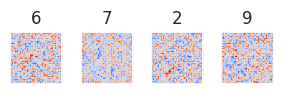

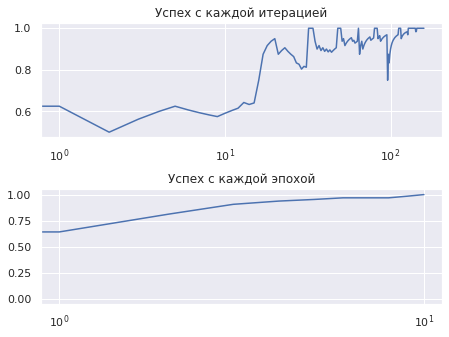

Точность классификации при тестировании: 1.0 



In [21]:
noise = PerceptronModel()

noise.reset_weights(-0.3, 0.3)
noise.train_epochs(train_speed=0.01,    dataset=get_data_set(train_folder), epochs=10)
noise.test(dataset=get_data_set(test_folder))

Скорость обучения: 0.01
Эпох: 10
Тепловая карта весов: 


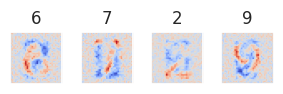

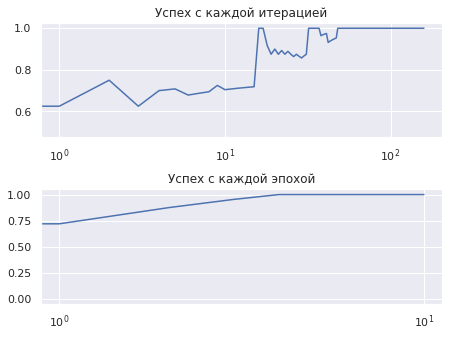

Точность классификации при тестировании: 1.0 



In [20]:
noise.reset_weights(-0.03, 0.03)
noise.train_epochs(train_speed=0.01,    dataset=get_data_set(train_folder), epochs=10)
noise.test(dataset=get_data_set(test_folder))

Скорость обучения: 0.01
Эпох: 4
Тепловая карта весов: 


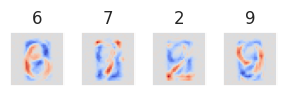

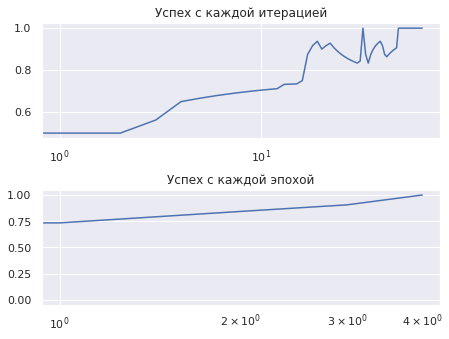

Точность классификации при тестировании: 1.0 



In [424]:
noise.reset_weights(-0.003, 0.003)
noise.train_epochs(train_speed=0.01,    dataset=get_data_set(train_folder), epochs=4)
noise.test(dataset=get_data_set(test_folder))